In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image

from os.path import join
import time

import torch
import torch.nn as nn
import torchvision
from torch import optim
from torchvision import transforms as tf
from torch.utils.data import DataLoader

from datasets import CachedDataset, MyDataset
from networks import AdaIN, EncoderVGG, Decoder
from loss import calculate_content_loss, calculate_style_loss

from utils import load_image, show_content_style_tradeoff_grid, show_style_and_content_img, multi_row_grid, show_images_in_a_row
import matplotlib.pyplot as plt

import numpy as np
import cv2

%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
device = torch.device('cuda:0')

In [5]:
tt = torch.randn(5)
tt.to(device)

tensor([ 0.4481, -0.4106, -0.2347, -0.7994, -0.1359], device='cuda:0')

In [6]:
content_img_path = 'C:/Users/Stefan/Desktop/Treca Godina/ORI/Image Captioning/ORI_ML/mscoco/train/img'
style_img_path = 'data/wikiart'

In [7]:
content_test_folder = 'images/input/content'
style_test_folder = 'images/input/style'
save_folder = 'saved_models/aws'

In [8]:
img_limit = 45000
cache_size = 11000
batch_size = 8 

In [9]:
transform = tf.Compose([
    tf.Resize(512),
    tf.RandomResizedCrop(256),
    tf.ToTensor()
])
test_transform = tf.Compose([
    tf.ToTensor(), 
#     tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # normalize to Gaussian(0,1)
])

test_transorm_crop = tf.Compose([
    tf.CenterCrop(512),
    tf.ToTensor(), 
])

test_inverse = tf.Compose([
    tf.ToPILImage()
])

In [10]:
encoder = EncoderVGG().to(device)

for net in encoder.subnets:
    net = net.to(device)

In [11]:
torch.cuda.empty_cache()

encoder = EncoderVGG().to(device)
for net in encoder.subnets:
    net = net.to(device)

adain = AdaIN().to(device)
decoder = Decoder(encoder).to(device)

decoder.load_state_dict(torch.load('saved_models/fin_45000_25style.pt'))

<All keys matched successfully>

In [11]:
decoder.load_state_dict(torch.load('saved_models/fin_45000_25style.pt'))

<All keys matched successfully>

In [12]:
start_lr =  1e-4
end_lr = 1e-5
optimizer = optim.Adam(decoder.parameters(), lr=start_lr)
criterion = nn.MSELoss()
c_weight = 10
s_weight = 50

In [13]:
num_epochs = 250
print_every = 1
show_result_every = 1
save_every = 3

In [14]:
# Calculate lr_decay from start, end learning rate and number of epochs
lr_decay = (start_lr / end_lr - 1) / num_epochs

In [15]:
def adjust_learning_rate(optimizer, epoch, start_lr=start_lr, lr_decay=lr_decay):
    new_lr = calculate_new_lr(start_lr, lr_decay, epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

def calculate_new_lr(start_lr, lr_decay, epoch):
    return start_lr / (1.0 + lr_decay * epoch)

In [16]:
def test(c_img, s_img, alpha=1., clamp=True):
#     torch.cuda.empty_cache()
#     encoder.eval()
#     decoder.eval()
    
    c_img = c_img.unsqueeze(0)
    s_img = s_img.unsqueeze(0)

    encoded_style_test = encoder(s_img)
    encoded_content_test = encoder(c_img)[-1]

    adain_out_test = adain(encoded_content_test, encoded_style_test[-1], alpha)

    out_img = decoder(adain_out_test).cpu().squeeze(0)
    if clamp:
        out_img = torch.clamp(out_img, -1, 1)
    return test_inverse(out_img)

In [17]:
def tensor_to_img(img, clamp=True):
    out_img = decoder(img).cpu().squeeze(0)
    print(out_img.size())
    
    if clamp:
        out_img = torch.clamp(out_img, -1, 1)
    return test_inverse(out_img)

def test_multiple2(content, style, alpha=1., clamp=True):
    encoded_style = encoder.forward_test(style)
    encoded_content = encoder.forward_test(content)
    
#     adain_out = adain(encoded_content, encoded_style)
    print('made it')
#     encoded_content_test = encoded_content.unbind(dim=0)
    adain_out_test = [adain(x.unsqueeze(0), encoded_style, alpha) for x in encoded_content]
    
    return [tensor_to_img(x) for x in adain_out_test]


def test_multiple(content, style, alpha=1., clamp=True):
    encoded_style = encoder.forward_test(style)
    encoded_content = encoder.forward_test(content)
    
#     adain_out = adain(encoded_content, encoded_style)
    print('made it')
#     encoded_content_test = encoded_content.unbind(dim=0)
    adain_out_test = [adain(x.unsqueeze(0), encoded_style, alpha) for x in encoded_content]
    
    return [tensor_to_img(x) for x in adain_out_test]

In [18]:
fixed_c_path = join(content_test_folder, 'golden_gate.jpg')
fixed_s_path = join(style_test_folder, 'la_muse.jpg')

fixed_c_img = test_transform(load_image(fixed_c_path)).to(device)
fixed_s_img = test_transform(load_image(fixed_s_path)).to(device)

In [19]:
num_imgs = 16
imgs = [fixed_c_img.unsqueeze(0) for _ in range(num_imgs)]

tt = torch.cat((*imgs,), 0)

In [46]:
from time import perf_counter

t1_start = perf_counter()
test_multiple(tt, fixed_s_img.unsqueeze(0))

t1_stop = perf_counter()
elapsed = t1_stop - t1_start
print(f'Total time: {elapsed}, time per img: {elapsed / len(tt)}')

made it
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
Total time: 2.8564738000000034, time per img: 0.1785296125000002


In [20]:
len(encoder.forward_test(fixed_c_img.unsqueeze(0)))

1

In [21]:
len(encoder(fixed_c_img.unsqueeze(0)))

4

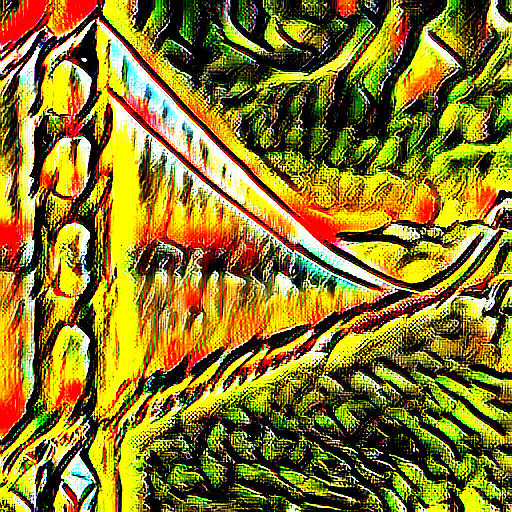

In [25]:
test(fixed_c_img, fixed_s_img, alpha=10)

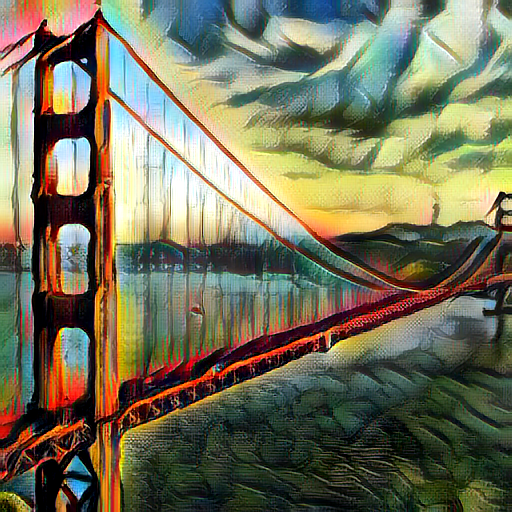

In [23]:
test(fixed_c_img, fixed_s_img, alpha=1)

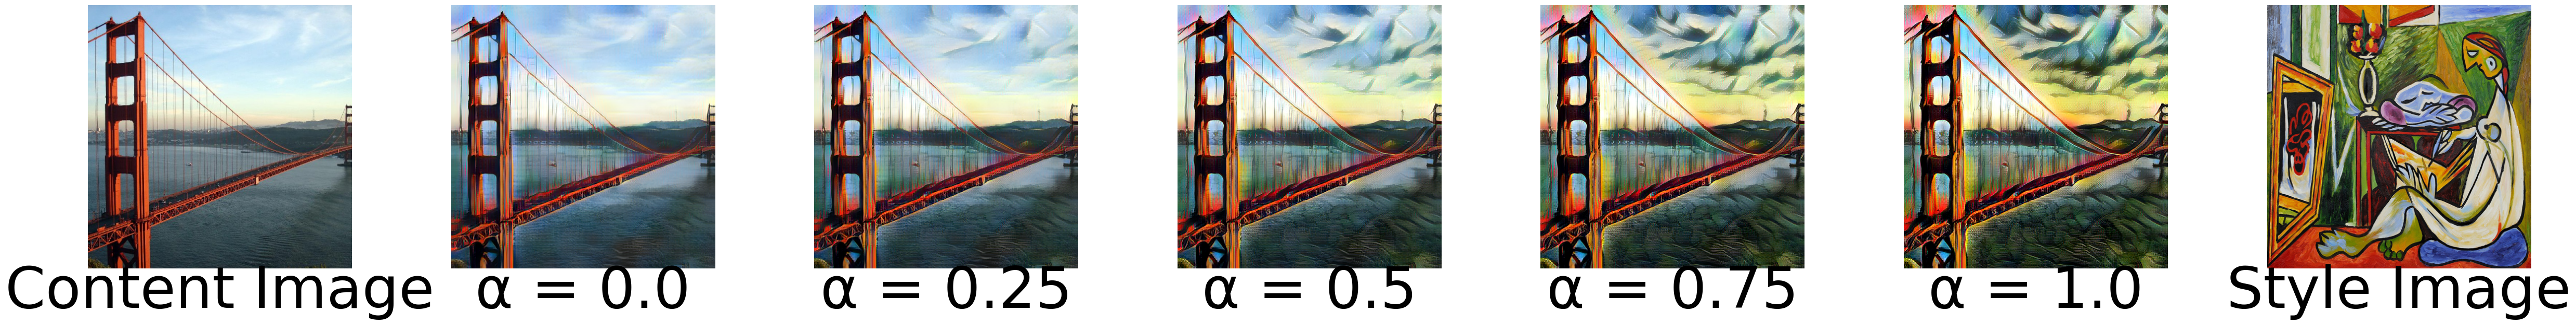

<Figure size 640x480 with 0 Axes>

In [24]:
show_content_style_tradeoff_grid(fixed_c_img, fixed_s_img, test, test_inverse)

In [22]:
fixed_c_path = join(content_test_folder, 'golden_gate.jpg')
fixed_s_path = join(style_test_folder, 'la_muse.jpg')

fixed_c_img = test_transform(load_image(fixed_c_path)).to(device)
fixed_s_img = test_transform(load_image(fixed_s_path)).to(device)

In [12]:
vidcap = cv2.VideoCapture('video/test_video.mp4')
fps = vidcap.get(cv2.CAP_PROP_FPS)

In [13]:
success, image = vidcap.read()
count = 1
    
while success and count < 500:
    if count % 1 == 0:
        cv2.imwrite("video/test_video_imgs/image_%d.jpg" % (count), image)    
        success, image = vidcap.read()
        print('Saved image ', count)
    count += 1

Saved image  1
Saved image  2
Saved image  3
Saved image  4
Saved image  5
Saved image  6
Saved image  7
Saved image  8
Saved image  9
Saved image  10
Saved image  11
Saved image  12
Saved image  13
Saved image  14
Saved image  15
Saved image  16
Saved image  17
Saved image  18
Saved image  19
Saved image  20
Saved image  21
Saved image  22
Saved image  23
Saved image  24
Saved image  25
Saved image  26
Saved image  27
Saved image  28
Saved image  29
Saved image  30
Saved image  31
Saved image  32
Saved image  33
Saved image  34
Saved image  35
Saved image  36
Saved image  37
Saved image  38
Saved image  39
Saved image  40
Saved image  41
Saved image  42
Saved image  43
Saved image  44
Saved image  45
Saved image  46
Saved image  47
Saved image  48
Saved image  49
Saved image  50
Saved image  51
Saved image  52
Saved image  53
Saved image  54
Saved image  55
Saved image  56
Saved image  57
Saved image  58
Saved image  59
Saved image  60
Saved image  61
Saved image  62
Saved image  63
S

In [18]:
ll = len(listdir("video/test_video_imgs"))

for i in range(1, ll + 1):

    video_image = test_transform(load_image(f"video/test_video_imgs/image_{i}.jpg")).to(device)

    x = test(video_image, style_img)
    x.save(f"video/out/hehe{i}.png")




NameError: name 'style_img' is not defined

In [15]:
from os import listdir

h, w, _ = cv2.imread("video/out/hehe1.png").shape
video = cv2.VideoWriter("video/output_video_1233213.avi", 0, fps, (w, h))


ll = len(listdir("video/out"))

for i in range(1, ll + 1):
    video.write(cv2.imread(f"video/out/hehe{i}.png"))
    
cv2.destroyAllWindows() 
video.release()

AttributeError: 'NoneType' object has no attribute 'shape'

In [20]:
style_test_folder = 'images/input/style'
style_img = test_transform(load_image(join(style_test_folder, '18299.jpg'))).to(device)

In [21]:
def make_video(input_video, style_img, skip=1):
    vidcap = cv2.VideoCapture(input_video)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    success, image = vidcap.read()
    h, w, _ = image.shape
    count = 1
    video_writer = cv2.VideoWriter("video/output_video_skip.mp4", 0, fps // skip, (w + 2, h))
    
    while success:
        if count % skip == 0:
            video_image = test_transform(image).to(device)
            out_image = test(video_image, style_img)
            cv_img = cv2.cvtColor(np.array(out_image), cv2.COLOR_RGB2BGR)
            video_writer.write(cv_img)
            print('Saved image ', count)
            
        success, image = vidcap.read()
        count += 1
    
    cv2.destroyAllWindows() 
    video_writer.release()

make_video("video/test_video.mp4", style_img, skip=1)

Saved image  1
Saved image  2
Saved image  3
Saved image  4
Saved image  5
Saved image  6
Saved image  7
Saved image  8
Saved image  9
Saved image  10
Saved image  11
Saved image  12
Saved image  13
Saved image  14
Saved image  15
Saved image  16
Saved image  17
Saved image  18
Saved image  19
Saved image  20
Saved image  21
Saved image  22
Saved image  23
Saved image  24
Saved image  25
Saved image  26
Saved image  27
Saved image  28
Saved image  29
Saved image  30
Saved image  31
Saved image  32
Saved image  33
Saved image  34
Saved image  35
Saved image  36
Saved image  37
Saved image  38
Saved image  39
Saved image  40
Saved image  41
Saved image  42
Saved image  43
Saved image  44
Saved image  45
Saved image  46
Saved image  47
Saved image  48
Saved image  49
Saved image  50
Saved image  51
Saved image  52
Saved image  53
Saved image  54
Saved image  55
Saved image  56
Saved image  57
Saved image  58
Saved image  59
Saved image  60
Saved image  61
Saved image  62
Saved image  63
S